In [1]:
%matplotlib inline

import pandas as pd
from IPython.display import HTML
import numpy as np
import matplotlib.image as mimg
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
import os, random, math, glob, tqdm
from base64 import b64encode
import warnings
warnings.filterwarnings('ignore')

In [ ]:
class NFL:
  def __init__(self):
    """
    https://www.kaggle.com/competitions/nfl-big-data-bowl-2022/data
    """
    self.game_link = "games.csv"
    self.play_link = "plays.csv"
    self.player_link = "players.csv"
    self.track_link = "track.csv"
    self.download()

  def download(self):
    self.game = pd.read_csv(self.game_link)
    self.play = pd.read_csv(self.play_link)
    self.player = pd.read_csv(self.player_link)
    self.track = pd.read_csv(self.track_link)

  def import_pbp_data(self, ls):
    season = self.game[self.game["season"].isin(ls)]
    game = self.play[self.play["gameId"].isin(season["gameId"])]
    play = self.track
    return play

In [ ]:
def save_play(penalty, game_id, play_id):
  nfl = NFL()
  pbp_data = nfl.import_pbp_data([2020])
  game_data = pbp_data[pbp_data["gameId"] == game_id] # Filter the data by game id
  mot = game_data[game_data["playId"] == play_id]
  img = mimg.imread('nfl.png')

  # Paste the original image onto the new image
  #mot["new_time"] = pd.to_datetime(mot["time"])
  #mot["frame"] = mot.new_time.dt.hour*60*60*1000+mot.new_time.dt.minute*60*1000+mot.new_time.dt.second*1000+mot.new_time.dt.microsecond//1000
  #65.32 -7.58
  #141.41 -13.05

  mot["new_x"] = (mot["x"]+13.05)/(141.41+13.05)*img.shape[1]
  mot["new_y"] = (mot["y"]+7.58)/(65.32+7.58)*img.shape[0]
  total_time = mot["frameId"].max()-mot["frameId"].min()
  min_time = mot["frameId"].min()

  os.makedirs("animations", exist_ok=True)
  penalty_pre = penalty.split(";")[0]
  os.makedirs("animations/"+penalty_pre, exist_ok=True)
  if os.path.exists("animations/"+penalty_pre+"/"+str(game_id)+"_"+str(play_id)+".mp4"):
      return
  fig, ax = plt.subplots(figsize=(12*2, 5.3*2))
  fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
  def animate(i):
      ax.clear()
      ax.imshow(img, aspect='auto')
      trck = mot[mot["frameId"]==min_time+i]
      sns.scatterplot(data=trck, x="new_x", y="new_y", hue="team", s=2).legend_.remove()
      for i in range(trck.shape[0]):
        id = trck['position'].iloc[i]
        if str(id)=="nan":
            id = "O"
        col = "green"
        if trck["team"].iloc[i]=="home":
            col="red"
        elif trck["team"].iloc[i]=="away":
            col="blue"
        ax.text(trck['new_x'].iloc[i], trck['new_y'].iloc[i], id, ha='center', va='center', color=col, weight='bold')
        theta = np.pi*(trck['o'].iloc[i]-90)/180.0
        dx = 10*trck['s'].iloc[i]*np.cos(theta)
        dy = 10*trck['s'].iloc[i]*np.sin(theta)
        ax.arrow(trck['new_x'].iloc[i], trck['new_y'].iloc[i], dx, dy)
        ax.axis('off')
  #animate(10)
  ani = animation.FuncAnimation(fig, animate, frames=total_time, interval=100)
  ani.save("animations/"+penalty_pre+"/"+str(game_id)+"_"+str(play_id)+".mp4")

In [ ]:
def save_all_penalties():
  nfl = NFL()
  season = nfl.game[nfl.game["season"].isin([2020])].gameId.unique()
  penalty_mask = nfl.play[nfl.play["gameId"].isin(season)]
  penalty_plays = penalty_mask[penalty_mask["penaltyCodes"].notnull()]
  for index, row in tqdm.tqdm(penalty_plays[["gameId", "playId", "penaltyCodes"]].iterrows()):
    try:
        save_play(row.penaltyCodes, row.gameId, row.playId)
    except:
        print(row.penaltyCodes, row.gameId, row.playId)

In [ ]:
def write_all_penalties():
  nfl = NFL()
  season = nfl.game[nfl.game["season"].isin([2020])].gameId.unique()
  penalty_mask = nfl.play[nfl.play["gameId"].isin(season)]
  penalty_plays = penalty_mask[penalty_mask["penaltyCodes"].notnull()]
  count = 0
  os.makedirs("animations", exist_ok=True)
  for index, row in penalty_plays.iterrows():
    count+=1
    #try:
    track_data = nfl.track[nfl.track["gameId"] == row.gameId] # Filter the data by game id
    mot = track_data[track_data["playId"] == row.playId]
    home = nfl.game[(nfl.game["gameId"]==row.gameId)].homeTeamAbbr.iloc[0]
    away = nfl.game[(nfl.game["gameId"]==row.gameId)].visitorTeamAbbr.iloc[0]
    foot = mot[mot["team"]=="football"]
    sns.lineplot(data=foot, y="s", x="frameId", label="football")
    players = row.penaltyJerseyNumbers.split(";")
    print(players)
    for i in players:
      print(i)
      team, jn = i.split(" ")
      if team==home:
        player = mot[(mot["team"]=="home") & (mot["jerseyNumber"]==int(jn))]
      else:
        player = mot[(mot["team"]=="away") & (mot["jerseyNumber"]==int(jn))]
      print(len(player))
      sns.lineplot(data=player, y="s", x="frameId", label=i)
    events = mot.event[mot.event.notnull()]
    for i in events:
      plt.axvline(x=mot[mot["event"]==i].frameId.unique()[0], color='r', linestyle='--')
      plt.text(mot[mot["event"]==i].frameId.unique()[0], 15, i, rotation=90, verticalalignment='center')
      plt.legend()
    plt.show()
    #except:
    #    print(row.penaltyCodes, row.gameId, row.playId)
    if(count>50):
      break

Here are the explanations for the NFL penalty codes you asked about:

- `FMM`: Face Mask (Major). This penalty is called when a player grabs an opponent's face mask in a harmful manner. It results in a 15-yard penalty and an automatic first down if committed by the defense.
- `IBW`: Illegal Block in the Back. This penalty is called when a player hits an opponent in the back outside of close line play. It results in a 10-yard penalty.
- `IDT`: I couldn't find a specific match for this code. It might be best to refer to the official NFL rulebook or contact NFL operations for more information.
- `UNS`: Unsportsmanlike Conduct. This penalty is called for various actions that violate the rules of sportsmanship, such as abusive language or gestures, excessive taunting, or unnecessary physical contact with an official.
- `POK`: I couldn't find a specific match for this code. It might be best to refer to the official NFL rulebook or contact NFL operations for more information.
- `OH`: Offensive Holding. This penalty is called when an offensive player uses his hands, arms, or other parts of his body to prevent a defensive player from pursuing the play. It results in a 10-yard penalty.
- `ITK`: I couldn't find a specific match for this code. It might be best to refer to the official NFL rulebook or contact NFL operations for more information.
- `UNR`: Unnecessary Roughness. This penalty is called when a player uses unnecessarily violent methods to tackle or block another player.
- `DOF`: Delay of Game, Defense. This penalty is called when a defensive player uses tactics that simulate the start of a play (like abrupt movements) to cause an offensive player to false start. It results in a 5-yard penalty.
- `UNRd`: Unnecessary Roughness, Defense. This is similar to Unnecessary Roughness but specifically called on a defensive player.
- `TRP`: Tripping. This penalty is called when a player uses his leg or foot to trip an opponent. It results in a 10-yard penalty.
- `ILF`: Illegal Formation. This penalty is called when the offensive team does not have at least seven players on the line of scrimmage at the snap, among other formation issues. It results in a 5-yard penalty.
- `UNSd`: Unsportsmanlike Conduct, Defense. This is similar to Unsportsmanlike Conduct but specifically called on a defensive player.
- `POK;OH`, `POK;ILF`, `UNRd;ILF`, `FCI;OH`, `OH;IBW`, and `POK;UNR` seem to indicate multiple penalties on a single play. For example, `POK;OH` would mean that both Poking Eyes and Offensive Holding were called on the same play.
- The rest of the codes (`CHB`, `OFK`, `RNK`, `HC`, `KCI`, `UOHd`, `ILH`, `IDP`, `TRPd`, `WED`, `IBB`, `DSQd`, and `IDK`) don't have clear matches based on my current knowledge and available resources.

Please note that these are general explanations and actual enforcement may vary based on specific game situations and league rules. For the most accurate information, it's always best to refer to the official NFL rulebook or contact NFL operations directly.

In [ ]:
game_id, play_id = 0, 0
penalties = ["FMM"]#, "IBW", "IDT", "OH", "POK", "UNS"]
penalty = random.choice(penalties)

def play_saved(penalty):
  files = glob.glob(os.path.join("animations/"+penalty+"/", "*.mp4"))
  print(files)
  def getinfo(s):
    if ".mp4" in s:
      s = s.split("/")[-1]
      nm = s.split("_")
      return int(nm[0]), int(nm[1][:-4])
  game_id, play_id = getinfo(random.choice(files))
  with open("animations/"+penalty+"/"+str(game_id)+"_"+str(play_id)+".mp4", "rb") as f:
    video_data = f.read()
    return video_data

HTML("""<video width=1600 controls><source src="data:video/mp4;base64,{0}" type="video/mp4" /></video>""".format(b64encode(play_saved(penalty)).decode()))

['animations/FMM/2020091301_2177.mp4', 'animations/FMM/2020091301_2590.mp4', 'animations/FMM/2020091302_740.mp4']


In [ ]:
nfl = NFL()

In [ ]:
nfl.track[nfl.track["team"]=="football"].event.unique()

array(['None', 'kickoff', 'touchback', 'ball_snap', 'extra_point_attempt',
       'extra_point', 'punt', 'fair_catch', 'kick_received',
       'first_contact', 'tackle', 'field_goal_attempt', 'field_goal',
       'punt_land', 'punt_downed', 'punt_received', 'out_of_bounds',
       'onside_kick', 'kickoff_land', 'autoevent_kickoff',
       'extra_point_missed', 'punt_fake', 'run', 'fumble',
       'fumble_defense_recovered', 'kick_recovered', 'field_goal_missed',
       'line_set', 'fumble_offense_recovered'], dtype=object)

In [ ]:
def find_all_penalties():
  nfl = NFL()
  season = nfl.game[nfl.game["season"].isin([2020])].gameId.unique()
  penalty_mask = nfl.play[nfl.play["gameId"].isin(season)]
  penalty_plays = penalty_mask[penalty_mask["penaltyCodes"].notnull()]
  count = 0
  for index, row in penalty_plays.iterrows():
    count+=1
    #try:
    track_data = nfl.track[nfl.track["gameId"] == row.gameId] # Filter the data by game id
    mot = track_data[track_data["playId"] == row.playId]
    home = nfl.game[(nfl.game["gameId"]==row.gameId)].homeTeamAbbr.iloc[0]
    away = nfl.game[(nfl.game["gameId"]==row.gameId)].visitorTeamAbbr.iloc[0]
    foot = mot[mot["team"]=="football"]
    sns.lineplot(data=foot, y="s", x="frameId", label="football")
    players = row.penaltyJerseyNumbers.split(";")
    print(players)
    for i in players:
      print(i)
      team, jn = i.split(" ")
      if team==home:
        player = mot[(mot["team"]=="home") & (mot["jerseyNumber"]==int(jn))]
      else:
        player = mot[(mot["team"]=="away") & (mot["jerseyNumber"]==int(jn))]
      print(len(player))
      sns.lineplot(data=player, y="s", x="frameId", label=i)
    events = mot.event[mot.event.notnull()]
    for i in events:
      plt.axvline(x=mot[mot["event"]==i].frameId.unique()[0], color='r', linestyle='--')
      plt.text(mot[mot["event"]==i].frameId.unique()[0], 15, i, rotation=90, verticalalignment='center')
      plt.legend()
    plt.show()
    #except:
    #    print(row.penaltyCodes, row.gameId, row.playId)
    if(count>50):
      break

['CLE 29']
CLE 29
106


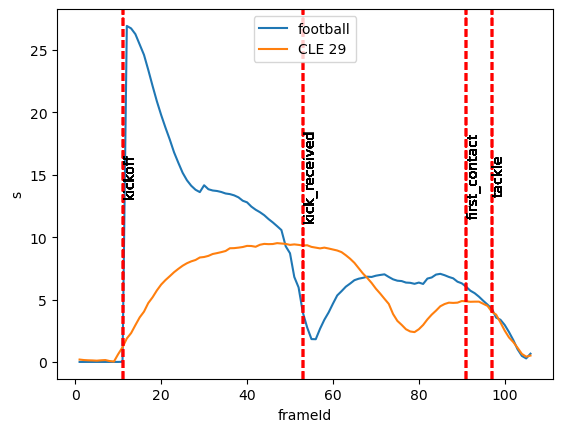

['CLE 20']
CLE 20
106


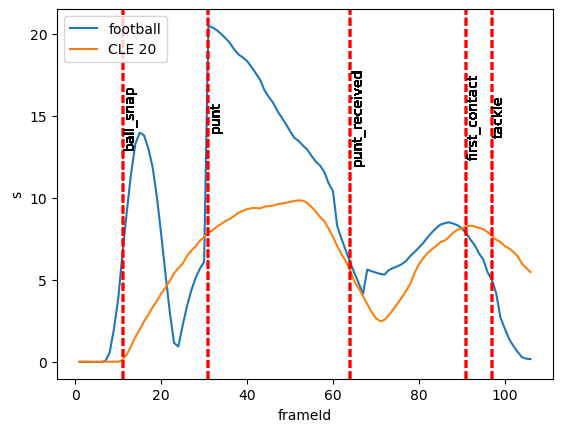

['NYJ 87']
NYJ 87
112


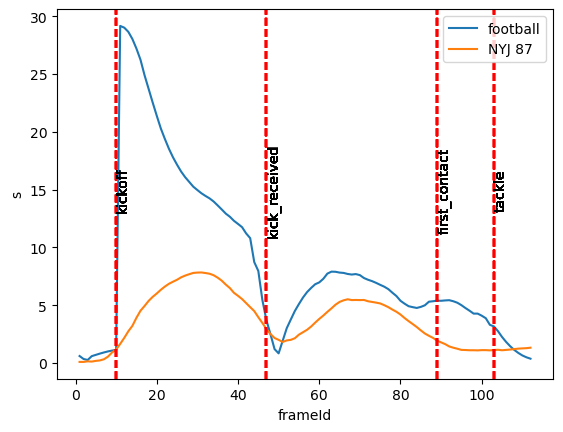

['BUF 13']
BUF 13
133


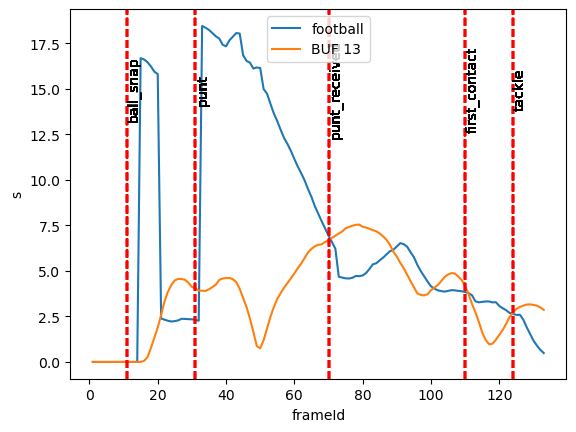

['CAR 28']
CAR 28
104


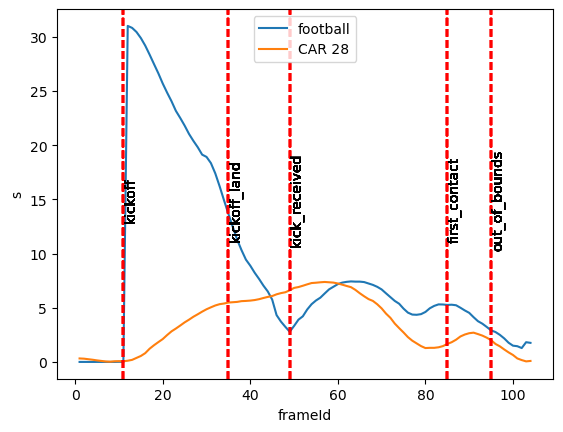

['CAR 36']
CAR 36
131


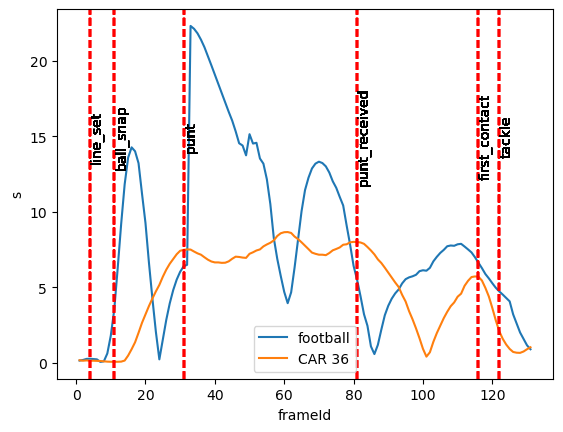

['CHI 84']
CHI 84
123


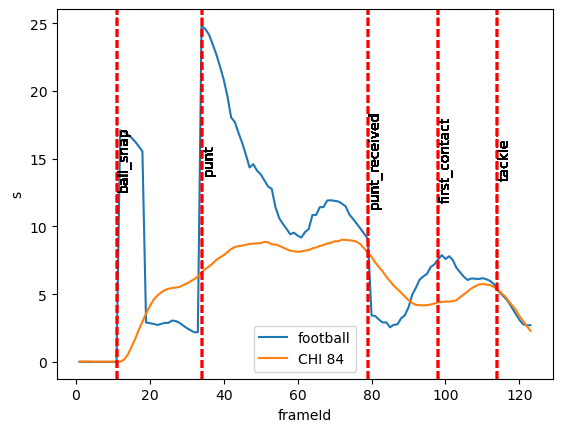

['PHI 52']
PHI 52
129


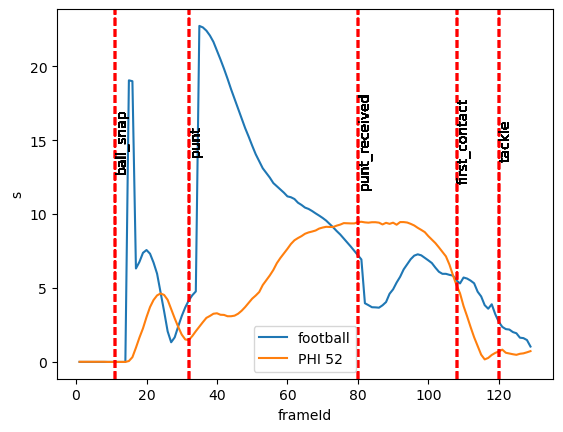

['LAC 12']
LAC 12
145


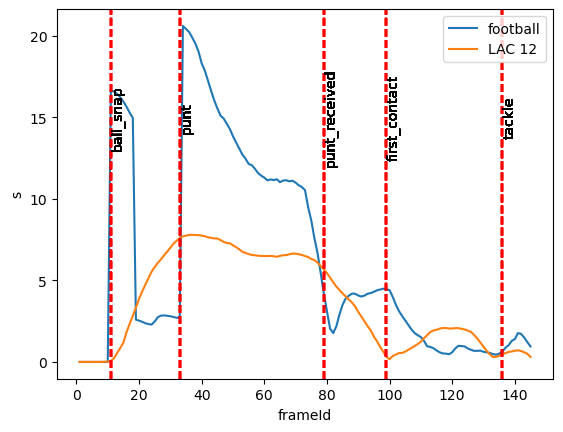

['LAC 24']
LAC 24
129


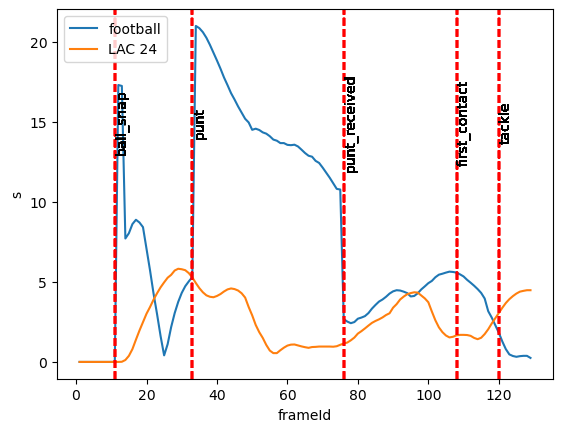

['TEN 37']
TEN 37
117


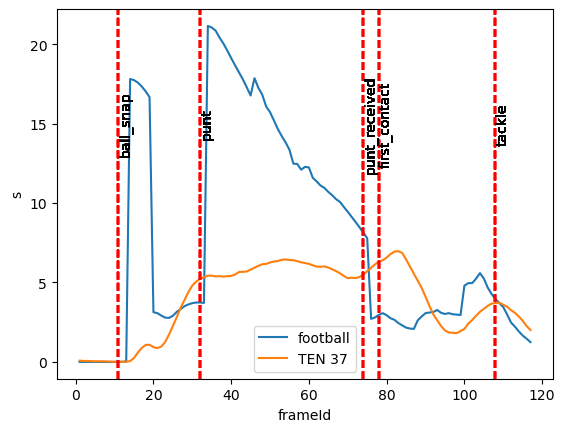

['DEN 37']
DEN 37
141


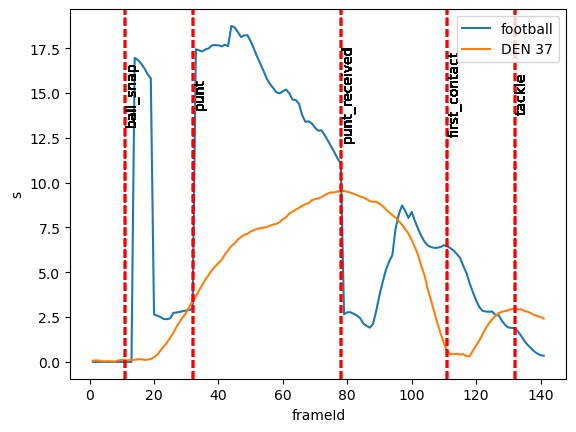

['CIN 59']
CIN 59
0


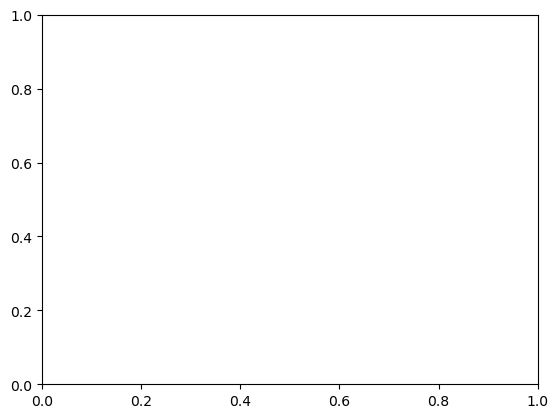

['NYG 28']
NYG 28
0


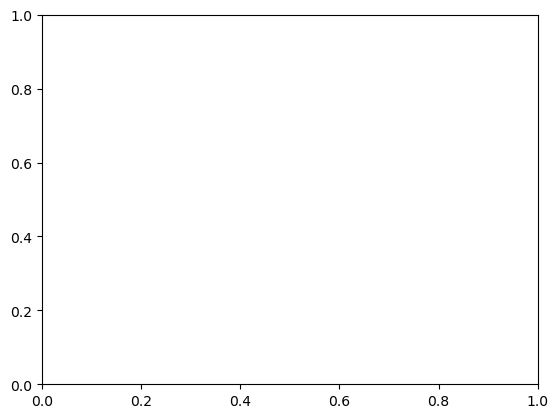

['DAL 37']
DAL 37
0


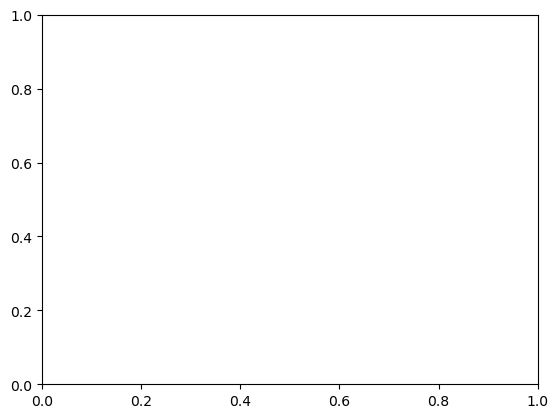

['ATL 17']
ATL 17
0


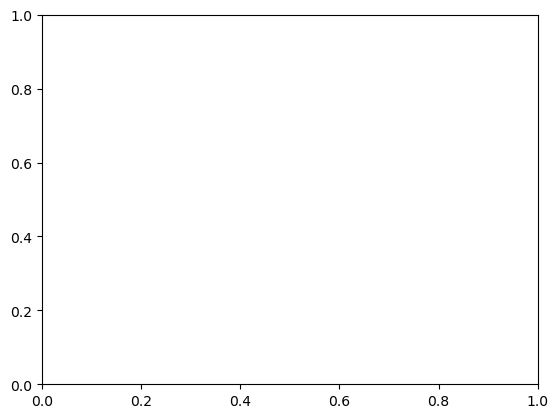

['GB 90']
GB 90
0


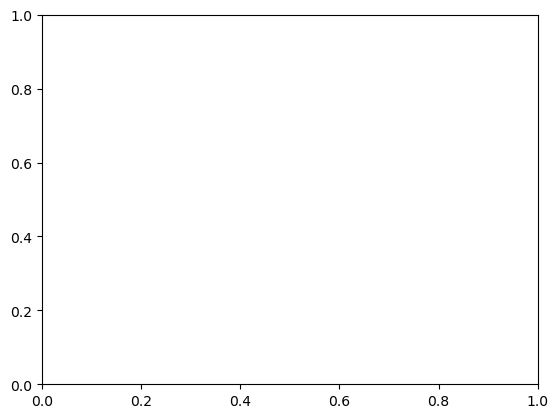

['DET 39']
DET 39
0


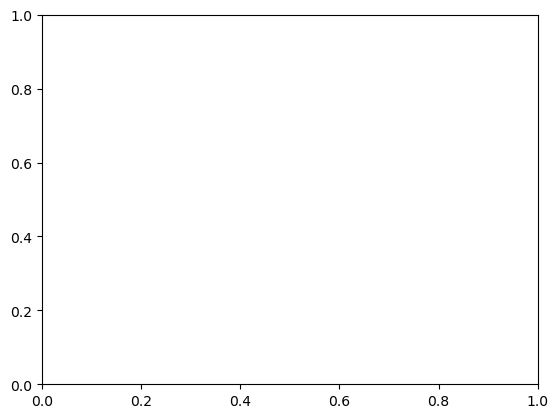

['IND 34']
IND 34
0


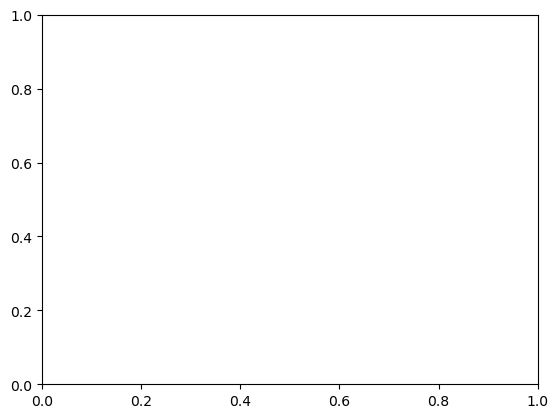

['BUF 25']
BUF 25
0


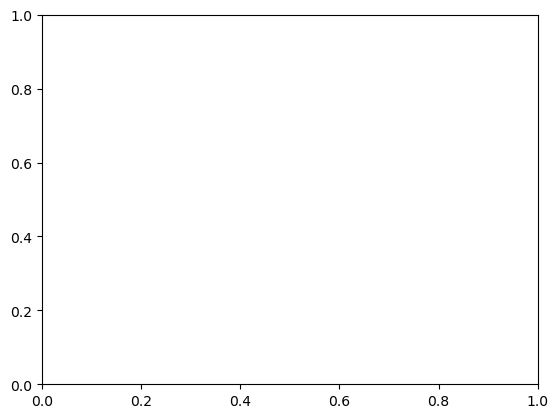

['NYJ 41']
NYJ 41
0


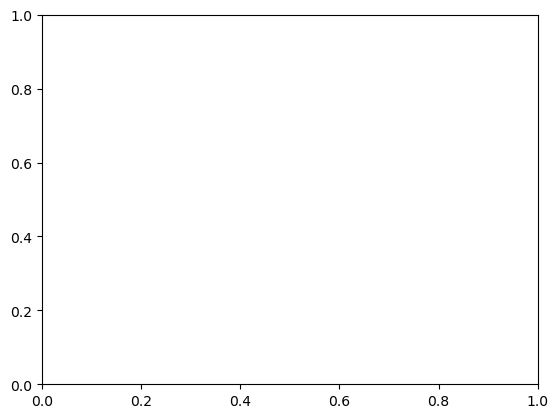

['LA']
LA


ValueError: not enough values to unpack (expected 2, got 1)

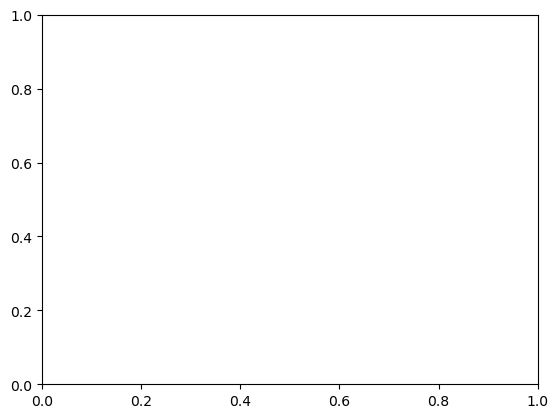

In [ ]:
find_all_penalties()